# Работа с git и dvc

In [1]:
! echo "# ml_model_Elon_tweets: forecasting summary Elon's tweets likes for each day" >> README.md
! git init
! git add README.md
! git commit -m "first commit"
! git branch -M main
! git remote add origin https://github.com/mariaa99/ml_model_Elon_tweets.git
! git push -u origin main

Initialized empty Git repository in C:/Users/badre/OneDrive/Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»/ml_model_Elon_tweets/.git/
[main (root-commit) 23cfef4] first commit
 1 file changed, 1 insertion(+)
 create mode 100644 README.md
branch 'main' set up to track 'origin/main'.


To https://github.com/mariaa99/ml_model_Elon_tweets.git
 * [new branch]      main -> main


In [2]:
! git add model_Elon_Mask.ipynb
! git commit -m "added notebook model_Elon_Mask.ipynb"

[main 439c065] added notebook model_Elon_Mask.ipynb
 1 file changed, 2227 insertions(+)
 create mode 100644 model_Elon_Mask.ipynb


In [3]:
! git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/mariaa99/ml_model_Elon_tweets.git
   23cfef4..439c065  main -> main


In [ ]:
! pip install dvc

In [16]:
! dvc init

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [1]:
! dvc add data/ElonTweets.csv


To track the changes with git, run:

	git add 'data\ElonTweets.csv.dvc' 'data\.gitignore'

To enable auto staging, run:

	dvc config core.autostage true


In [2]:
!git add data/ElonTweets.csv.dvc data/.gitignore
!git commit -m "Add data"

[main 63681f0] Add data
 5 files changed, 11 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 data/.gitignore
 create mode 100644 data/ElonTweets.csv.dvc


In [5]:
! dvc remote add -f myremote  gdrive://1rNr65eRkNkjC56RXXkY1vVYkAn7NWHWj
! dvc remote default myremote   
! git add .dvc/config
! git commit -m "Configure remote storage"

[main 953e3db] Configure remote storage
 1 file changed, 2 insertions(+)


In [6]:
! dvc push

Everything is up to date.


In [7]:
! dvc pull -f

Everything is up to date.


# Загружаем необходимые библиотеки

In [8]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import sktime
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.ets import AutoETS
from sklearn.ensemble import GradientBoostingRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\badre\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Считываем и преобразуем данные

In [9]:
! dvc pull -f

Everything is up to date.


In [10]:
df = pd.read_csv("data/ElonTweets.csv", sep = ',')
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%Y.%m.%d %H:%M:%S")
df['Date'] = pd.to_datetime(df['Date'], format="%Y.%m.%d")
df = df[['Date','Datetime', 'Text', 'location', 'reply count', 'retweet count', 'like count', 'Follower Count',  'sentiment' ]]
df

,Date,Datetime,Text,location,reply count,retweet count,like count,Follower Count,sentiment
0,2022-10-28,2022-10-28 03:49:11+00:00,the bird is freed,Twitter HQ,57663,128631,730472,110553384,"['positive', 0.70848316]"
1,2022-10-28,2022-10-28 01:50:49+00:00,Falcon rockets to orbit as seen from LA https:...,Twitter HQ,6857,16499,189436,110553384,"['neutral', 0.90077394]"
2,2022-10-27,2022-10-27 21:45:47+00:00,@Gfilche @Twitter 🤣,Twitter HQ,632,246,7052,110553384,"['neutral', 0.5714027]"
3,2022-10-27,2022-10-27 16:17:39+00:00,@PeterSchiff 🤣 thanks,Twitter HQ,670,420,17577,110553384,"['positive', 0.78971434]"
4,2022-10-27,2022-10-27 13:19:25+00:00,@ZubyMusic Absolutely,Twitter HQ,1281,1152,42896,110553384,"['neutral', 0.5287457]"
...,...,...,...,...,...,...,...,...,...
17440,2011-12-03,2011-12-03 08:22:07+00:00,That was a total non sequitur btw,Twitter HQ,27,9,51,110555351,"['negative', 0.5067324]"
17441,2011-12-03,2011-12-03 08:20:28+00:00,"Great Voltaire quote, arguably better than Twa...",Twitter HQ,23,29,53,110555351,"['positive', 0.55860823]"
17442,2011-12-01,2011-12-01 10:29:04+00:00,I made the volume on the Model S http://t.co/w...,Twitter HQ,29,13,75,110555351,"['neutral', 0.6384011]"
17443,2011-12-01,2011-12-01 09:55:11+00:00,Went to Iceland on Sat to ride bumper cars on ...,Twitter HQ,33,22,188,110555351,"['positive', 0.9733198]"


### Посмотрим минимальную и максимальную дату

In [11]:
(df['Date'].min(), df['Date'].max())

(Timestamp('2010-06-04 00:00:00'), Timestamp('2022-10-28 00:00:00'))

### Преобразование данных из поля sentiment в 2 отдельных поля

In [12]:
df['sentiment_type'] = np.nan 
df['sentiment_rate'] = np.nan 
for i in df.index:
    df['sentiment_type'][i] = str(df['sentiment'][i][1:-1].split(', ')[0][1:-1])
    df['sentiment_rate'][i] = float(df['sentiment'][i][1:-1].split(', ')[1])
df

,Date,Datetime,Text,location,reply count,retweet count,like count,Follower Count,sentiment,sentiment_type,sentiment_rate
0,2022-10-28,2022-10-28 03:49:11+00:00,the bird is freed,Twitter HQ,57663,128631,730472,110553384,"['positive', 0.70848316]",positive,0.708483
1,2022-10-28,2022-10-28 01:50:49+00:00,Falcon rockets to orbit as seen from LA https:...,Twitter HQ,6857,16499,189436,110553384,"['neutral', 0.90077394]",neutral,0.900774
2,2022-10-27,2022-10-27 21:45:47+00:00,@Gfilche @Twitter 🤣,Twitter HQ,632,246,7052,110553384,"['neutral', 0.5714027]",neutral,0.571403
3,2022-10-27,2022-10-27 16:17:39+00:00,@PeterSchiff 🤣 thanks,Twitter HQ,670,420,17577,110553384,"['positive', 0.78971434]",positive,0.789714
4,2022-10-27,2022-10-27 13:19:25+00:00,@ZubyMusic Absolutely,Twitter HQ,1281,1152,42896,110553384,"['neutral', 0.5287457]",neutral,0.528746
...,...,...,...,...,...,...,...,...,...,...,...
17440,2011-12-03,2011-12-03 08:22:07+00:00,That was a total non sequitur btw,Twitter HQ,27,9,51,110555351,"['negative', 0.5067324]",negative,0.506732
17441,2011-12-03,2011-12-03 08:20:28+00:00,"Great Voltaire quote, arguably better than Twa...",Twitter HQ,23,29,53,110555351,"['positive', 0.55860823]",positive,0.558608
17442,2011-12-01,2011-12-01 10:29:04+00:00,I made the volume on the Model S http://t.co/w...,Twitter HQ,29,13,75,110555351,"['neutral', 0.6384011]",neutral,0.638401
17443,2011-12-01,2011-12-01 09:55:11+00:00,Went to Iceland on Sat to ride bumper cars on ...,Twitter HQ,33,22,188,110555351,"['positive', 0.9733198]",positive,0.973320


### Агрегируем данные по дате и найдем суммарное количество лайков в каждую дату

In [13]:
df_agg = df.groupby('Date').agg({'like count': 'sum'})
df_agg

,like count
Date,
2010-06-04,6023
2011-12-01,263
2011-12-03,104
2011-12-04,163
2011-12-21,2480
...,...
2022-10-24,180048
2022-10-25,409389
2022-10-26,1976784


### Построим графики для визуального определения паттернов временного ряда

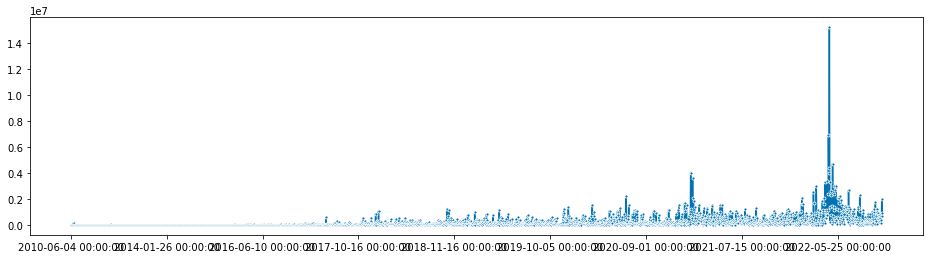

In [14]:
fig, ax = plot_series(df_agg, markers = '.')

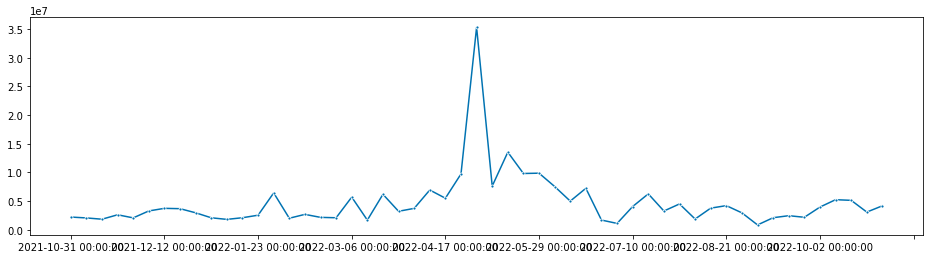

In [15]:
fig, ax = plot_series(df_agg['2021-10-28':].resample('W').sum(), markers = '.')

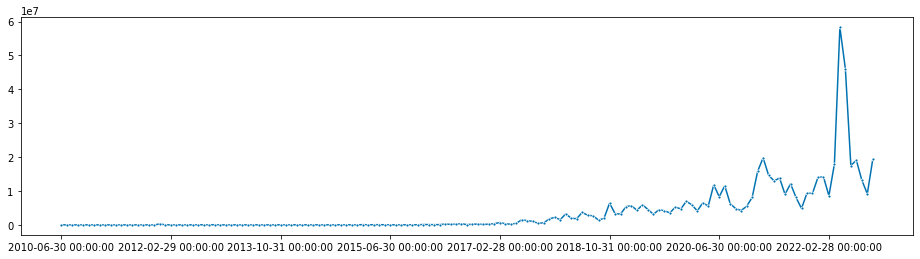

In [16]:
fig, ax = plot_series(df_agg.resample('M').sum(), markers = '.')

**Видим, что ряд имеет восходящий характер и некоторую сезонность**

### Выберем для рассмотрения и дальнейшего прогнозирования временной промежуток: 2 последних года

In [17]:
df = df_agg.resample('M').sum()
df = df['2018-10-31':]
df.reset_index(names='Date',inplace = True)
df

,Date,like count
0,2018-10-31,6419230
1,2018-11-30,3344606
2,2018-12-31,3197145
3,2019-01-31,5400388
4,2019-02-28,5670607
5,2019-03-31,4293393
6,2019-04-30,5952838
7,2019-05-31,4543787
8,2019-06-30,3138439
9,2019-07-31,4496910


# Записываем предобработанные данные в csv

In [18]:
df.to_csv('data/ElonTweets_new.csv', sep=';') 

# Добавляем новый датасет для трекинга в dvc

In [19]:
! dvc add data/ElonTweets_new.csv


To track the changes with git, run:

	git add 'data\.gitignore' 'data\ElonTweets_new.csv.dvc'

To enable auto staging, run:

	dvc config core.autostage true


In [20]:
!git add data/ElonTweets_new.csv.dvc  data/.gitignore
!git commit -m "Add new data"

[main a8be398] Add new data
 2 files changed, 5 insertions(+)
 create mode 100644 data/ElonTweets_new.csv.dvc


In [21]:
! git add .dvc/config
! git commit -m "Configure remote storage"

On branch main
Your branch is ahead of 'origin/main' by 5 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   model_Elon_Mask.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/

no changes added to commit (use "git add" and/or "git commit -a")


In [22]:
! dvc push

Everything is up to date.


In [23]:
! dvc pull

Everything is up to date.


# Считываем предобработанные данные
Будем передавать эти данные в модель

In [24]:
df = pd.read_csv("data/ElonTweets_new.csv", sep = ';', usecols=[1, 2])
df['Date'] = pd.to_datetime(df['Date'], format="%Y.%m.%d")
df.set_index('Date', inplace = True)
df

,like count
Date,
2018-10-31,6419230
2018-11-30,3344606
2018-12-31,3197145
2019-01-31,5400388
2019-02-28,5670607
2019-03-31,4293393
2019-04-30,5952838
2019-05-31,4543787
2019-06-30,3138439


# Построение модели прогнозированния временного ряда
Наша модель будет предсказывать кол-во лайков твитов Илона Маска 


# Предсказание на текущих данных (без прогноза на будущее)

 Создаем функцию, в которой объединим дополнительную обработку данных для прогнозирования, в том числе разбиение на тестовую и обучающую выборки, а также саму модель 

#### Модель: GradientBoostingRegressor

In [25]:
def model_predictions_GB(df):
    df = df.astype('float64')
    index = pd.to_datetime(df.index, format="%Y-%m-%d")
    df['week'] = index.month
    df['week_num'] = range(1, len(df) + 1)
    for i in range(1,13):
            df['season_' + str(i)] =  df['week'] == i
    season_columns = [ 'season_' + str(i) for i in range(2,13)]
    # Разделяем на features и target
    X = df[['week_num'] + season_columns]
    y = df['like count']
    # Создаем обучающую и тестовые выборки
    X_train = X[:'2021-10-31']
    y_train = y[:'2021-10-31']
    X_test = X['2021-10-31' :]
    y_test = y['2021-10-31' :]
    # Обучаем модель 
    GBR = GradientBoostingRegressor().fit(X_train.iloc[:, :12], y_train)
    y_pred = GBR.predict(X.iloc[:, :12])
    # Формируем датасет для выхода
    y_pred = pd.DataFrame(data=y_pred, index=y.index, columns=['cnt_predictions'])
    y_test = pd.DataFrame(data=y_test.values, index=y_test.index, columns=['cnt'])
    y = pd.DataFrame(data=y.values, index=y.index, columns=['cnt'])
    df_predictions = pd.concat([y,y_pred], axis = 1)
    print('MAРE = %.3f' % (mean_absolute_percentage_error(y_test, y_pred['2021-10-31':'2022-10-31'], symmetric=False)))
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return df_predictions

#### Модель: AutoETS

In [26]:
def model_predictions_ETS(df):
    df = df.asfreq('M')
    y_train  = df[:'2021-10-31']
    y_test  = df['2021-10-31' :]

    fh = ForecastingHorizon(df.index, is_relative=None)
    forecaster = AutoETS(auto=True, sp = 12, n_jobs=1) # автоматический выбор модели, а вообще дефолтные параметры подходят

    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    print('MAРE = %.3f' % (mean_absolute_percentage_error(y_test, y_pred['2021-10-31':'2022-10-31'], symmetric=False)))
    # Формируем датасет для выхода
    y_pred.rename(columns = {'cnt' : 'cnt_predictions'}, inplace = True)
    df_predictions = pd.concat([df,y_pred], axis = 1)
    return df_predictions

## Вызываем функции для прогнозирования
Она выводит датасет, график и метрику MAPE

#### Модель: GradientBoostingRegressor

MAРE = 0.389


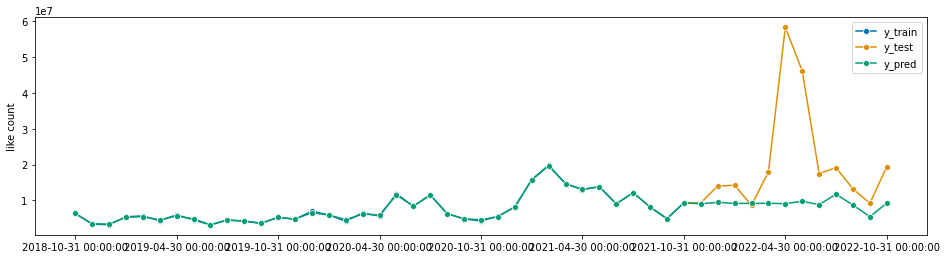

In [27]:
df_pred_GB = model_predictions_GB(df)

#### Модель: AutoETS

MAРE = 0.407


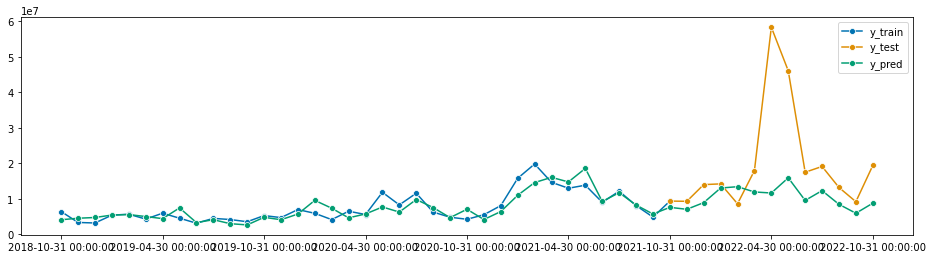

In [28]:
df_pred_ETS = model_predictions_ETS(df)

# Предсказание на будущих данных (прогноз в будущее на 6 месяцев вперед)

#### Модель: AutoETS

In [29]:
def model_predictions_ETS_future(df):
    y_train  = df[:'2021-10-31']
    y_test  = df['2021-10-31' :]

    fh = ForecastingHorizon(pd.date_range(start = '2021-10-30', periods = 18, freq = 'M'), is_relative=None)
    forecaster = AutoETS(auto=True, sp = 12, n_jobs=1) # автоматический выбор модели, а вообще дефолтные параметры подходят

    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    print('MAРE = %.3f' % (mean_absolute_percentage_error(y_test, y_pred['2021-10-31':'2022-10-31'], symmetric=False)))
    # Формируем датасет для выхода
    y_pred.rename(columns = {'cnt' : 'cnt_predictions'}, inplace = True)
    df_predictions = pd.concat([df,y_pred], axis = 1)
    return df_predictions

#### Модель: GradientBoostingRegressor

In [30]:
def model_predictions_GB_future(df):
    index = pd.date_range(df.index.max() + relativedelta(months=1), periods = 5, freq = 'M')
    index = pd.to_datetime(index, format="%Y-%m-%d")
    new_dates = pd.DataFrame(index.month, index=index )
    new_dates.rename(columns =  {0: 'week'}, inplace = True)
    df = pd.concat([df,new_dates])
    df = df.astype('float64')
    index = pd.to_datetime(df.index, format="%Y-%m-%d")
    df['month'] = index.month
    df['month_num'] = range(1, len(df) + 1)
    for i in range(1,13):
            df['season_' + str(i)] =  df['month'] == i
    season_columns = [ 'season_' + str(i) for i in range(2,13)]
    # Разделяем на features и target
    X = df[['month_num'] + season_columns]
    y = df['like count']

    # Создаем обучающую и тестовые выборки
    X_train = X[:'2021-10-30']
    y_train = y[:'2021-10-30']
    X_test = X['2021-10-31' :]
    y_test = y['2021-10-31' :]
    # Обучаем модель 
    GBR = GradientBoostingRegressor().fit(X_train.iloc[:, :12], y_train)
    y_pred = GBR.predict(X_test.iloc[:, :12])
    # Формируем датасет для выхода
    y_pred = pd.DataFrame(data=y_pred, index=y_test.index, columns=['cnt_predictions'])
    y_test = pd.DataFrame(data=y_test.values, index=y_test.index, columns=['cnt'])
    y = pd.DataFrame(data=y.values, index=y.index, columns=['cnt'])
    print('MAРE = %.3f' % (mean_absolute_percentage_error(y_test['2021-10-31':'2022-10-31'], y_pred['2021-10-31':'2022-10-31'], symmetric=False)))
    plt = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    #plt.xticks(rotation=90)
    y.reset_index(inplace = True)
    y_pred.reset_index(inplace = True)
    df_predictions = y.merge(y_pred, how='left', on='index')
    df_predictions.set_index('index', inplace = True)
    #df_predictions = df_predictions.drop(columns=['level_0_x','level_0_y'])
    return df_predictions

## Вызываем функции для прогнозирования

#### Модель: AutoETS

MAРE = 0.407


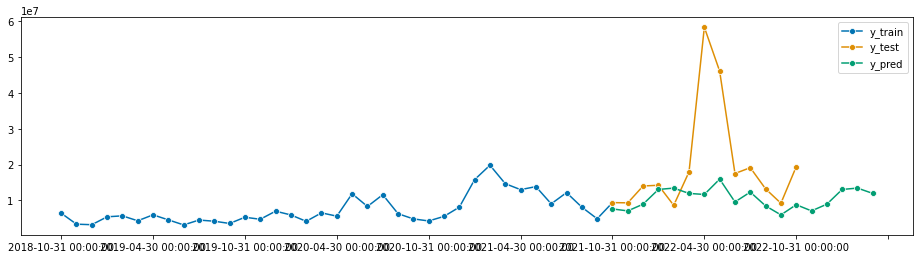

In [31]:
df_pred_ETS = model_predictions_ETS_future(df)

#### Модель: GradientBoostingRegressor

MAРE = 0.544


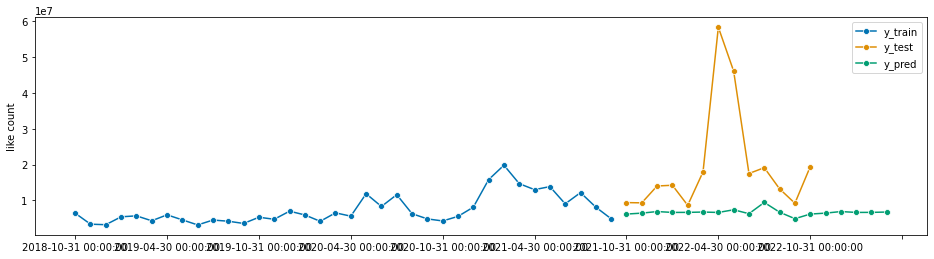

In [32]:
df_pred_GB = model_predictions_GB_future(df)

# Выкладываем в github

In [33]:
! git add model_Elon_Mask.ipynb 
! git commit -m "Add last version of notebook"

[main 343ddad] Add last version of notebook
 1 file changed, 91 insertions(+), 96 deletions(-)


In [34]:
!git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/mariaa99/ml_model_Elon_tweets.git
   439c065..343ddad  main -> main
